## Likelihood-free inference in non-Gaussian stochastic volatility models

This tutorial

In [1]:
import os
import pandas as pd
import torch
import pyro
import pyro.distributions as dist
from matplotlib import pyplot
from torch.distributions import constraints
from pyro import poutine
from pyro.infer import SVI, Trace_CRPS, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal, init_to_feasible
from pyro.optim import ClippedAdam


%matplotlib inline
%config InlineBackend.rc = {'figure.facecolor': (1, 1, 1, 1)}
%config InlineBackend.figure_formats = ['svg']

In [2]:
#df = pd.read_csv(os.path.expanduser("~/Downloads/snp500.csv"))
df = pd.read_csv(os.path.expanduser("~/Downloads/KO.csv"))

In [3]:
x = torch.tensor(df["Close"]).float()
# torch.save(x, os.path.expanduser("~/Downloads/snp500_daily_open.pkl"))

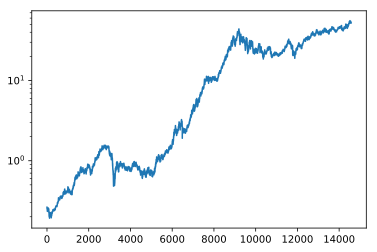

In [4]:
pyplot.plot(x)
pyplot.yscale('log')

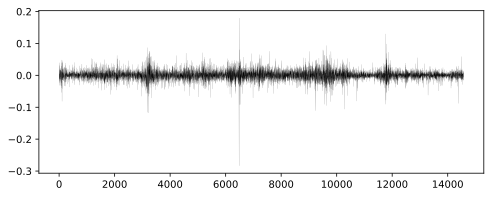

In [5]:
pyplot.figure(figsize=(8, 3), dpi=300)
r = (x[1:] / x[:-1]).log()
pyplot.plot(r, "k", lw=0.1);

mean = 0.00036403367994353175
std = 0.014571567066013813


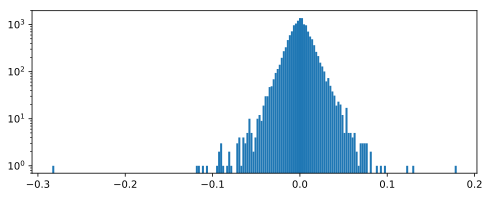

In [6]:
pyplot.figure(figsize=(8, 3))
pyplot.hist(r, bins=200)
pyplot.yscale('log')
print("mean = {}".format(r.mean()))
print("std = {}".format(r.std()))

First let's fit a single distribution to the returns.

In [7]:
def model():
    stability = pyro.param("stability", torch.tensor(1.9),
                           constraint=constraints.interval(0, 2))
    skew = pyro.param("skew", torch.tensor(0.), constraint=constraints.interval(0, 2))
    scale = pyro.param("scale", torch.tensor(1.), constraint=constraints.positive)
    loc = pyro.param("loc", torch.tensor(0.))
    with pyro.plate("data", len(r)):
        return pyro.sample("r", dist.Stable(stability, skew, scale, loc), obs=r)

step 0 loss = 66.15467834472656
step 20 loss = 3.3294215202331543
step 40 loss = 1.9694565534591675
step 60 loss = 1.3346726894378662
step 80 loss = 1.2710012197494507
step 100 loss = 1.2698975801467896
step 120 loss = 1.2568941116333008
step 140 loss = 1.2341169118881226
step 160 loss = 1.2439030408859253
step 180 loss = 1.2426338195800781
step 200 loss = 1.248765468597412
loc = 0.00011247562360949814
scale = 0.010724909603595734
skew = 2.350988701644575e-38
stability = 1.9909183979034424
CPU times: user 15.3 s, sys: 809 ms, total: 16.1 s
Wall time: 2.7 s


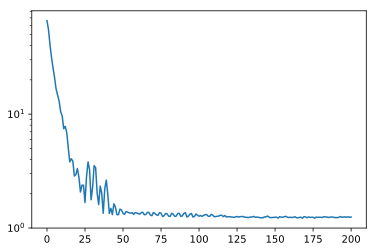

In [8]:
%%time
pyro.clear_param_store()
pyro.clear_param_store()
pyro.set_rng_seed(1234567890)
pyro.enable_validation(True)
num_steps = 201
optim = ClippedAdam({"lr": 0.2, "lrd": 0.1 ** (1 / num_steps)})
svi = SVI(model, lambda: None, optim, Trace_CRPS())
losses = []
for step in range(num_steps):
    loss = svi.step()
    losses.append(loss)
    if step % 20 == 0:
        print("step {} loss = {}".format(step, loss))
pyplot.plot(losses)
pyplot.yscale('log')
for name, value in sorted(pyro.get_param_store().items()):
    if value.numel() == 1:
        print("{} = {}".format(name, value.squeeze().item()))

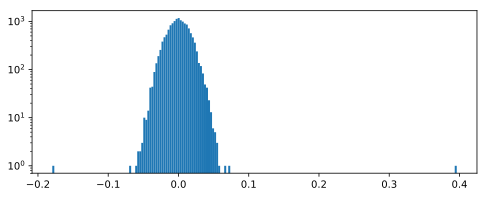

In [9]:
samples = poutine.uncondition(model)().detach()
pyplot.figure(figsize=(8, 3), dpi=300)
pyplot.hist(samples, bins=200)
pyplot.yscale('log')

This is a poor fit, but that's to be expected since we're mixing all time steps together: we would expect this to be a scale-mixture of distributions (Normal, StudentT, or Stable), but are modeling it as a single distribution (Stable in this case).

## Modeling in Pyro

Consider a stochastic volatity model of the log returns `r_t` and a latent volatility `h`:
$$
  \log h_t = \delta + \phi \log h_{t-1} + \sigma v_t \\
  r_t = w_t \sqrt{h_t}
$$
Usually $\sigma v_1$ and $w_t$ are both Gaussian. We will generalize to Student t and Stable distributions.

In [10]:
class Process(dist.TorchDistribution):
    arg_constraints = {}
    def __init__(self, size, decay, trans_dist):
        self.decay = decay
        self.trans_dist = trans_dist
        batch_shape = trans_dist.batch_shape
        event_shape = (size,)
        super().__init__(batch_shape, event_shape)
    @property
    def support(self):
        return self.trans_dist.support
    def expand(self, shape):
        return Process(
            self.event_shape[0],
            self.decay,
            self.trans_dist.expand(shape))
    def log_prob(self, series):
        # Effectively unsqueeze self.trans_dist
        if isinstance(self.trans_dist, dist.Normal):
            trans_dist = dist.Normal(self.trans_dist.loc.unsqueeze(-1),
                                     self.trans_dist.scale.unsqueeze(-1))
        elif isinstance(self.trans_dist, dist.StudentT):
            trans_dist = dist.StudentT(self.trans_dist.df.unsqueeze(-1),
                                       self.trans_dist.loc.unsqueeze(-1),
                                       self.trans_dist.scale.unsqueeze(-1))
        else:
            raise NotImplementedError(type(self.trans_dist))
        diff = series[1:] - series[:-1] * self.decay
        return trans_dist.log_prob(diff).sum(-1)

class Model:
    def __init__(self, process_type="normal", obs_type="normal"):
        self.process_type = process_type
        self.obs_type = obs_type
        
    def __call__(self, data):
        # We experiment with three types of process noise.
        timescale = pyro.sample("timescale", dist.LogNormal(10, 3))
        h_decay = (-1 / timescale).exp()
        if self.process_type == "normal":
            h_dist = dist.Normal(0, timescale.rsqrt())
        elif self.process_type == "studentt":
            h_df = pyro.sample("h_df", dist.Gamma(3, 1))
            h_dist = dist.StudentT(h_df, timescale.rsqrt())
        else:
            raise ValueError("unsupported process_type: {}".format(self.process_type))
        noise = pyro.sample("noise", Process(len(data), h_decay, h_dist))
        if noise.dim() >= 2:
            noise = noise.squeeze(-2)
        
        h_loc = pyro.sample("h_loc", dist.Normal(0, 3))
        h_scale = pyro.sample("h_scale", dist.LogNormal(-10, 3))
        log_h = h_loc + h_scale * noise
        sqrt_h = log_h.mul(0.5).exp()

        # We experiment with two types of observation noise.
        r_loc = pyro.sample("r_loc", dist.Normal(0, 1e-2))
        if self.obs_type == "normal":
            r_dist = dist.Normal(r_loc, sqrt_h)
        elif self.obs_type == "studentt":
            r_df = pyro.sample("r_df", dist.Gamma(3, 1))
            r_dist = dist.StudentT(r_df, r_loc, sqrt_h)
        elif self.obs_type == "stable":
            r_stability = pyro.sample("r_stability", dist.Uniform(0.5, 2.0))
            r_skew = pyro.sample("r_skew", dist.Uniform(-1, 1))
            r_dist = dist.Stable(r_stability, r_skew, sqrt_h, r_loc)
        else:
            raise ValueError("unsupported obs_type: {}".format(self.obs_type))
        with pyro.plate("time", len(data)):
            r = pyro.sample("r", r_dist, obs=data)

        return log_h.detach(), r.detach()

In [11]:
def init_loc_fn(site):
    inits = {
        "h_loc": torch.tensor(0.),
        "timescale": torch.tensor(10.),
        "h_df": torch.tensor(10.),
        "h_scale": torch.tensor(0.1),
        "r_df": torch.tensor(10.),
        "r_stability": torch.tensor(1.9),
        "r_skew": torch.tensor(0.),
        "r_loc": torch.tensor(0.),
    }
    if site["name"] in inits:
        return inits[site["name"]]
    return init_to_feasible(site)

In [12]:
def train(model, guide, optim, loss):
    svi = SVI(model, guide, optim, loss)
    losses = []
    for step in range(401):
        loss = svi.step(r)
        losses.append(loss)
        if step % 20 == 0:
            print("step {} loss = {}".format(step, loss))
    for name, value in sorted(guide.median().items()):
        if value.numel() == 1:
            print("{} = {}".format(name, value.squeeze().item()))
    pyplot.plot(losses)

In [13]:
from pyro import poutine

@torch.no_grad()
def predict(model, guide, data):
    trace = poutine.trace(guide).get_trace(data)
    with poutine.replay(trace=trace), poutine.uncondition():
        return model(data)

predictions = {}

def add_prediction(model, guide, data):
    predictions[model.process_type, model.obs_type] = predict(model, guide, data)

In [14]:
def train_elbo(model, num_steps=1001):
    pyro.clear_param_store()
    pyro.set_rng_seed(1234567890)
    pyro.enable_validation(True)
    guide = AutoDiagonalNormal(model, init_loc_fn=init_loc_fn)
    optim = ClippedAdam({
        "lr": 0.02,
        "betas": (0.9, 0.99),
        "lrd": 0.1 ** (1 / num_steps),
    })
    svi = SVI(model, guide, optim, Trace_ELBO())
    losses = []
    for step in range(num_steps):
        loss = svi.step(r)
        losses.append(loss)
        if step % 50 == 0:
            print("step {} loss = {}".format(step, loss))
    pyplot.plot(losses)
    for name, value in sorted(guide.median().items()):
        if value.numel() == 1:
            print("{} = {}".format(name, value.squeeze().item()))
    add_prediction(model, guide, r)

step 0 loss = 22869.563948631287
step 50 loss = 11867.257819414139
step 100 loss = 5153.439316868782
step 150 loss = -873.9233348071575
step 200 loss = -7883.112490415573
step 250 loss = -16344.504331469536
step 300 loss = 182795.72070622444
step 350 loss = -32949.63006198406
step 400 loss = -36263.190908551216
step 450 loss = -31369.89772605896
step 500 loss = -37578.76932859421
step 550 loss = -36995.15536427498
step 600 loss = -38811.24026608467
step 650 loss = -38748.725863575935
step 700 loss = -37960.231602191925
step 750 loss = -38721.3898191452
step 800 loss = -39051.716604352
step 850 loss = -38508.562878489494
step 900 loss = -39097.21186721325
step 950 loss = -39261.883397459984
step 1000 loss = -39180.8736230135
h_loc = -4.843145370483398
h_scale = 5.232349395751953
r_loc = 0.0002534033847041428
timescale = 23.07419776916504
CPU times: user 6.81 s, sys: 342 ms, total: 7.15 s
Wall time: 7.19 s


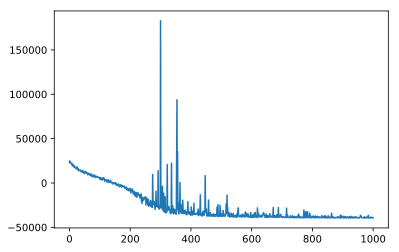

In [15]:
%%time
model = Model("normal", "normal")
train_elbo(model)

step 0 loss = 23269.78163766861
step 50 loss = 13469.058198451996
step 100 loss = 5052.876153200865
step 150 loss = -1761.6116066277027
step 200 loss = -11131.51040673256
step 250 loss = -15856.863041877747
step 300 loss = -21492.1995139122
step 350 loss = -35040.509660959244
step 400 loss = -36868.06441402435
step 450 loss = -36043.169194459915
step 500 loss = -35588.87790226936
step 550 loss = -37718.52320599556
step 600 loss = -37569.612917780876
step 650 loss = -38735.89824604988
step 700 loss = -38389.84741914272
step 750 loss = -38735.10103452206
step 800 loss = -39017.35943341255
step 850 loss = -39279.34215414524
step 900 loss = -39270.46621334553
step 950 loss = -39274.79792523384
step 1000 loss = -38621.92610383034
h_loc = -4.624843120574951
h_scale = 5.819023132324219
r_df = 30.224563598632812
r_loc = 0.0020374003797769547
timescale = 24.789220809936523
CPU times: user 8.23 s, sys: 521 ms, total: 8.75 s
Wall time: 8.68 s


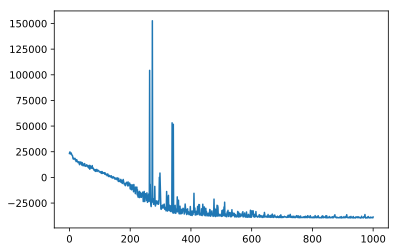

In [16]:
%%time
model = Model("normal", "studentt")
train_elbo(model)

step 0 loss = 40544.64763045311
step 50 loss = 22172.141691565514
step 100 loss = 5673.521495372057
step 150 loss = -4924.728994011879
step 200 loss = -16544.272127389908
step 250 loss = -15101.119287848473
step 300 loss = -27908.85986930132
step 350 loss = -30306.08303028345
step 400 loss = -32348.123653829098
step 450 loss = -33606.042504668236
step 500 loss = -28743.27429896593
step 550 loss = -33641.31803685427
step 600 loss = -35055.74071902037
step 650 loss = -36626.93224209547
step 700 loss = -36777.58755457401
step 750 loss = -35876.36429673433
step 800 loss = -37058.15045809746
step 850 loss = -37353.199710428715
step 900 loss = -37408.35692846775
step 950 loss = -37809.930992126465
step 1000 loss = -37354.619469463825
h_df = 59.839656829833984
h_loc = -5.817907333374023
h_scale = 1.8192360401153564
r_loc = -0.0010928575647994876
timescale = 4951.1435546875
CPU times: user 7.75 s, sys: 415 ms, total: 8.17 s
Wall time: 8.13 s


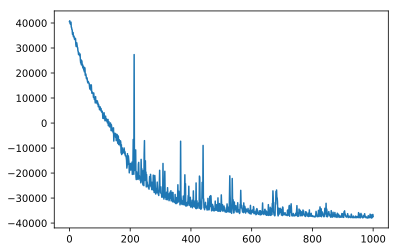

In [17]:
%%time
model = Model("studentt", "normal")
train_elbo(model)

step 0 loss = 40929.02621078491
step 50 loss = 20939.348917365074
step 100 loss = 6174.182244360447
step 150 loss = -4769.567916534841
step 200 loss = -15586.429593741894
step 250 loss = -16563.794689416885
step 300 loss = -30316.617069482803
step 350 loss = -27387.47313839197
step 400 loss = -31758.254174232483
step 450 loss = -34479.935466349125
step 500 loss = -34972.66912609339
step 550 loss = -31760.64203608036
step 600 loss = -36555.03186172247
step 650 loss = -33434.71526145935
step 700 loss = -36625.68317270279
step 750 loss = -36943.352750480175
step 800 loss = -37525.32085955143
step 850 loss = -37288.77697044611
step 900 loss = -37243.928968667984
step 950 loss = -37781.976767003536
step 1000 loss = -37183.4253371954
h_df = 59.10047149658203
h_loc = -6.093899726867676
h_scale = 1.8612524271011353
r_df = 15.300773620605469
r_loc = 0.00024677044712007046
timescale = 5272.33984375
CPU times: user 11 s, sys: 719 ms, total: 11.7 s
Wall time: 11.8 s


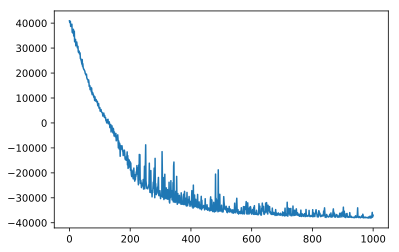

In [18]:
%%time
model = Model("studentt", "studentt")
train_elbo(model)

In [19]:
def train_crps(model, num_steps=1001):
    pyro.clear_param_store()
    pyro.set_rng_seed(1234567890)
    pyro.enable_validation(True)
    guide = AutoDiagonalNormal(model, init_loc_fn=init_loc_fn, init_scale=0.01)
    optim = ClippedAdam(lambda name, _: {
        "lr": 0.1 if name.startswith("Auto") else 0.01,
        "betas": (0.9, 0.99),
        "lrd": 0.1 ** (1 / num_steps),
    })
    svi = SVI(model, guide, optim, Trace_CRPS(prior_scale=0))
    losses = []
    for step in range(num_steps):
        loss = svi.step(r)
        losses.append(loss)
        if step % 50 == 0:
            print("step {} loss = {}".format(step, loss))
    pyplot.plot(losses)
    pyplot.yscale('log')
    for name, value in sorted(guide.median().items()):
        if value.numel() == 1:
            print("{} = {}".format(name, value.squeeze().item()))
    add_prediction(model, guide, r)

step 0 loss = 59.190887451171875
step 50 loss = 2.744127035140991
step 100 loss = 1.3680068254470825
step 150 loss = 1.7880672216415405


/Users/fritzobermeyer/github/uber/pyro/pyro/infer/trace_crps.py:189: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/Users/fritzobermeyer/github/uber/pyro/pyro/util.py:73: UserWarning: Encountered NaN: r_skew
  value.register_hook(lambda x: warn_if_nan(x, msg))
/Users/fritzobermeyer/github/uber/pyro/pyro/util.py:73: UserWarning: Encountered NaN: r_stability
  value.register_hook(lambda x: warn_if_nan(x, msg))
/Users/fritzobermeyer/github/uber/pyro/pyro/util.py:73: UserWarning: Encountered NaN: r_loc
  value.register_hook(lambda x: warn_if_nan(x, msg))
/Users/fritzobermeyer/github/uber/pyro/pyro/util.py:73: UserWarning: Encountered NaN: h_scale
  value.register_hook(lambda x: warn_if_nan(x, msg))
/Users/fritzobermeyer/github/uber/pyro/pyro/util.py:73: UserWarning: Encountered NaN: h_loc
  value.register_hook(lambda x: warn_if_nan(x, msg))
/Users/fritzobermeyer/github/uber/pyro/pyro/util.py:73: UserWarning: Encountered NaN: noise
  value.register_hook(lambda x: warn_if_na

step 200 loss = 1.248170018196106
step 250 loss = 1.3597854375839233
step 300 loss = 1.4333040714263916
step 350 loss = 1.2321032285690308
step 400 loss = 1.21940279006958
step 450 loss = 1.3407014608383179
step 500 loss = 1.2704349756240845
step 550 loss = 1.0658215284347534
step 600 loss = 1.296635627746582
step 650 loss = 1.368526816368103
step 700 loss = 1.22487211227417
step 750 loss = 1.264069676399231
step 800 loss = 1.372567892074585
step 850 loss = 1.2628837823867798
step 900 loss = 1.185673713684082
step 950 loss = 1.2302042245864868
step 1000 loss = 1.2636032104492188
h_loc = -5.449619770050049
h_scale = 2.447554588317871
r_loc = -0.0011674847919493914
r_skew = 0.3455897569656372
r_stability = 1.9896081686019897
timescale = 10.0
CPU times: user 1min 27s, sys: 2.6 s, total: 1min 30s
Wall time: 13.6 s


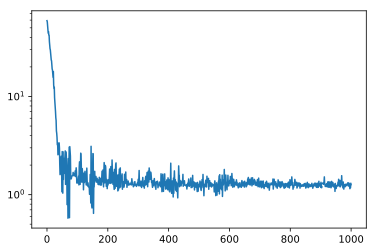

In [20]:
%%time
model = Model("normal", "stable")
train_crps(model)

In [21]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


step 0 loss = 57.10508728027344
step 50 loss = 2.1066417694091797
step 100 loss = 0.3803563117980957
step 150 loss = 1.4585821628570557
step 200 loss = 1.5289826393127441
step 250 loss = 2.2853660583496094
step 300 loss = 1.4848618507385254
step 350 loss = 0.7383632659912109
step 400 loss = 2.0953760147094727
step 450 loss = 1.3236180543899536
step 500 loss = 1.1710184812545776
step 550 loss = 1.564112901687622
step 600 loss = 1.3131444454193115
step 650 loss = 3.51617431640625
step 700 loss = 1.598834753036499
step 750 loss = 1.675250768661499
step 800 loss = 1.700035572052002
step 850 loss = 1.3328596353530884
step 900 loss = 1.103821873664856
step 950 loss = 1.3666974306106567
step 1000 loss = 1.2797785997390747
h_df = 10.0
h_loc = -5.404378890991211
h_scale = 2.6203720569610596
r_loc = -0.000664096383843571
r_skew = 0.39046549797058105
r_stability = 1.9889005422592163
timescale = 10.0
CPU times: user 1min 31s, sys: 2.23 s, total: 1min 34s
Wall time: 13.9 s


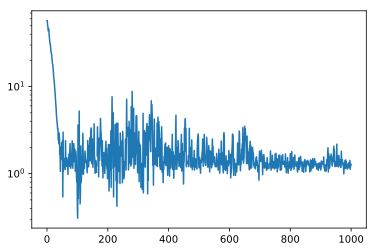

In [22]:
%%time
model = Model("studentt", "stable")
train_crps(model)

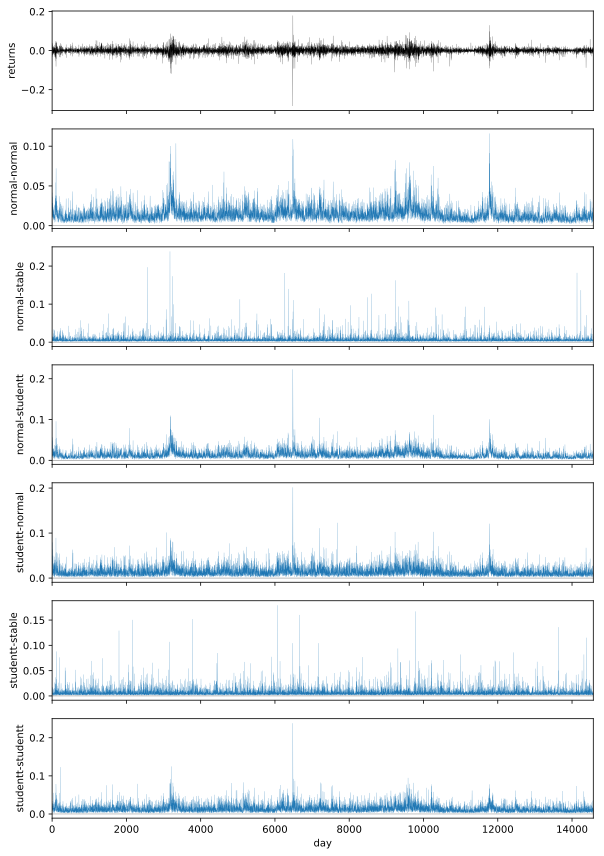

In [23]:
fig, axes = pyplot.subplots(1 + len(predictions), figsize=(8.5, 12), sharex=True)
axes[0].plot(r, "k", lw=0.2)
axes[0].set_ylabel("returns")
axes[0].set_xlim(0, len(r))
for key, ax in zip(sorted(predictions), axes[1:]):
    log_h, r_pred = predictions[key]
    ax.plot(log_h.mul(0.5).exp(), lw=0.2)
    ax.set_ylabel("-".join(key))
ax.set_xlabel("day")
pyplot.tight_layout()